In [1]:
# af_indirs = snakemake.params.af_indirs
# indir = snakemake.params.indir
# outdir = snakemake.params.outdir
# donor = int(snakemake.wildcards.d)
# weights = snakemake.params.weights
# anno_cells_meta_f = snakemake.input.anno_cells_meta_f
# objectives_l = snakemake.params.get("objectives_l", 
#                                     ["variants_with_clone_norm_by_1_over_nclones_with_variant", 
#                                      "max_clone_ncells_over_nclones", "max_clone_ncells_over_ncells", 
#                                      "pct_thresh","other_pct_thresh", 
#                                      "n_vars", "obj_nclones_more_than_one_unique"])
try: 
    af_indirs = snakemake.params.af_indirs
    indir = snakemake.params.indir
    outdir = snakemake.params.outdir
    donor = int(snakemake.wildcards.d)
    weights = snakemake.params.weights
    anno_cells_meta_f = snakemake.input.anno_cells_meta_f
    objectives_l = snakemake.params.get("objectives_l", 
                                        ["variants_with_clone_norm_by_1_over_nclones_with_variant", 
                                         "max_clone_ncells_over_nclones", "max_clone_ncells_over_ncells", 
                                         "pct_thresh","other_pct_thresh", 
                                         "n_vars", "obj_nclones_more_than_one_unique"])
except NameError:
    af_indirs = "/data/Mito_Trace/output/pipeline/v04/CHIP_b2/InputOnly/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_prefilterMerge_impute/knn/kparam_30/"
    indir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/mt_clones_thresh/scrap/donor0"
    outdir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/mt_clones_thresh/scrap/donor0"
    donor = 0
    anno_cells_meta_f = "/data/Mito_Trace/output/pipeline/v04/CHIP_b2/InputOnly/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_prefilterMerge_impute/knn/kparam_30/gff_A2_black/annotation_clones/se_cells_meta_labels.tsv"
    weights = [1,1,1,1,-1, 1, 1]
    objectives_l = ["variants_with_clone_norm_by_1_over_nclones_with_variant", 
                    "max_clone_ncells_over_nclones", "max_clone_ncells_over_ncells", 
                    "pct_thresh","other_pct_thresh", "n_vars", "obj_nclones_more_than_one_unique"] #"nvars"

    
param_names = ["pct_thresh","af_thresh", "other_pct_thresh"]


In [2]:
## Remove any weights and objectives with 0 
temp_obj = []
temp_weights = []
for ind, o in enumerate(objectives_l):
    if weights[ind] != 0:
        temp_weights.append(weights[ind])
        temp_obj.append(o)
weights = temp_weights
objectives_l = temp_obj
print(objectives_l)
print(weights)

['variants_with_clone_norm_by_1_over_nclones_with_variant', 'max_clone_ncells_over_nclones', 'max_clone_ncells_over_ncells', 'pct_thresh', 'other_pct_thresh', 'n_vars', 'obj_nclones_more_than_one_unique']
[1, 1, 1, 1, -1, 1, 1]


In [4]:
import src.clone_variants_optim  as optim
from mplh import cluster_help as ch

from dynamicTreeCut import cutreeHybrid
from scipy.spatial.distance import pdist
import numpy as np
from scipy.cluster.hierarchy import linkage

import mplh.cluster_help as ch
import mplh.fig_utils as fu

%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join, exists, dirname
from glob import glob
import pickle
from icecream import ic
ic.disable()
np.set_printoptions(formatter={'float': lambda x: format(x, '.3f')})
# matplotlib.rcParams['ps.useafm'] = False
# matplotlib.rcParams['pdf.use14corefonts'] = True
# matplotlib.rcParams['text.usetex'] = False

fig_utils from mplh


# Load results and get top results

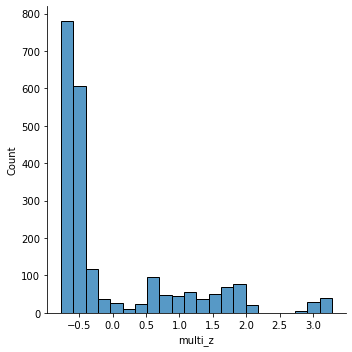

In [6]:
obj_norm_results = pd.read_csv(join(indir, "objectives_norm.csv"), index_col=0)
param_results = pd.read_csv(join(indir, "params.csv"), index_col=0)

from scipy.stats import zscore
obj_norm_results["multi_z"] = zscore(obj_norm_results["multi"])
sns.displot(obj_norm_results["multi_z"])

## Get the top objective result based on the distribution of scores. 1D cluster scores and take cluster with highest mean. Number of clusters determined using the loss and the elbow plot with kneedle

In [7]:
from sklearn import mixture
from sklearn import metrics

X = obj_norm_results[["multi_z"]]
# from sklearn.mixture import GMM
scores_d = {}
#labels_d = {}
for n in np.arange(2,11):
    print('n', n)
    model = mixture.GaussianMixture(n_components=n, covariance_type='full', max_iter=200, tol=0.0001)
    gmm = model.fit(X)
    max_index = np.argmax(gmm.means_[:,0])
    
    scores_d[n] = dict()
    scores_d[n]["aic"] = gmm.aic(X)
    scores_d[n]["bic"] = gmm.bic(X)
    scores_d[n]["likelihood"] = gmm.score(obj_norm_results[["multi_z"]])
    scores_d[n]["max_index"] = max_index
    labels = gmm.predict(X)
    labels_df = pd.DataFrame({"all_cluster_labels":labels, "multi_z": obj_norm_results["multi_z"] }, 
                             index=obj_norm_results.index)
    labels_df["all_cluster_labels"] = labels_df["all_cluster_labels"].astype(object)
    #labels = pd.DataFrame({"all_cluster_labels":labels}, index=obj_norm_results.index)
    sns.displot(data=labels_df, x="multi_z",hue="all_cluster_labels", palette="hls")#, s=40, cmap='viridis')
    plt.title(f"nclusters {n}")
    scores_d[n]["all_cluster_labels"] = labels_df
    

scores_df = pd.DataFrame(scores_d).transpose()
scores_df


from kneed import DataGenerator, KneeLocator
count = 0
kneedle = KneeLocator(scores_df.index, scores_df["likelihood"], S=2.0, curve="concave", 
                      direction="increasing", online=True)
while kneedle.knee is None and count < 10 : 
    kneedle = KneeLocator(scores_df.index, scores_df["likelihood"], S=2.0, curve="concave", 
                          direction="increasing", online=True)
    count += 1
try:
    kneedle.plot_knee_normalized()
except:
    print("kneedle plot error")
max_n = kneedle.knee
# if max_n is None:
#     max_n = 
print(f'best n: {kneedle.knee}')
scores_df["n"] = scores_df.index
plt.figure()
sns.scatterplot(data=scores_df, x="n", y="likelihood")
if kneedle.knee is not None:
    plt.axvline(kneedle.knee, color='g')#, axis=plt.gca())
plt.savefig(join(outdir, "elbow_multi_obj_nclust.pdf"))

### Get params in top cluster and plot top results


labels_df = scores_d[max_n]["all_cluster_labels"] 

max_index = scores_d[max_n]["max_index"]
print('max_index', max_index)
max_scores = labels_df[labels_df["all_cluster_labels"] == max_index]
max_scores

f, ax = plt.subplots(nrows=2, ncols=1, squeeze=True)
sns.histplot(data=labels_df, x="multi_z",hue="all_cluster_labels", palette="hls", ax=ax[0])#, s=40, cmap='viridis')
plt.title(f"nclusters {max_n}")
ax[0].set_yscale('log', base=2)
labels_df["keep"] = labels_df["all_cluster_labels"] == max_index

sns.histplot(data=labels_df, x="multi_z",hue="keep", palette="hls", ax=ax[1])#, s=40, cmap='viridis')
plt.title(f"nclusters {max_n}")
ax[1].set_yscale('log', base=2)
plt.tight_layout()
plt.savefig(join(outdir, f"multi_clusters_nclust_{max_n}.pdf"), bbox_inches='tight', pad_inches=1)

#plt.savefig(join(outdir, f"multi_clusters_nclust_{max_n}_filt.pdf"))


sns.distplot(obj_norm_results.loc[max_scores.index,"multi_z"])

obj_norm_maxClust = obj_norm_results.loc[max_scores.index].drop("multi_z", axis=1)
#obj_norm_maxClust_params
sns.displot(obj_norm_maxClust["multi"])
print(f"number of param sets used: {obj_norm_maxClust.shape[0]}")
# obj_norm_maxClust = obj_norm_results.iloc[:top10perc_n]
obj_norm_maxClust_params = pd.merge(left=obj_norm_maxClust, 
                                            right=param_results, left_index=True, right_index=True, how="left", 
                                            suffixes=["_obj", ""])


param_results = param_results.loc[obj_norm_maxClust.index]


## Cluster top results by objectives and get a dynamic tree cut of the dendrogram

multi_top = zscore(obj_norm_maxClust.drop("multi", axis=1).fillna(0).values)
multi_top = pd.DataFrame(multi_top)
multi_top = multi_top.loc[:, ~(multi_top.isnull().all())]
multi_top

distances = pdist(multi_top.values, "cosine")
link = linkage(distances, "average")
clusters = cutreeHybrid(link, distances, minClusterSize=1)["labels"]
clusters = pd.DataFrame({"labels": clusters}, index=obj_norm_maxClust.index)#[["ID", "labels"]]

clusters["ID"] = obj_norm_maxClust.index
to_clust_df = obj_norm_maxClust.drop("multi", axis=1).apply(lambda x: zscore(x)).fillna(0)
to_clust_df = to_clust_df.loc[~((to_clust_df==0).all(axis=1)), ~((to_clust_df==0).all(axis=0))]
g=ch.plot_cluster(to_clust_df, 
                row_meta=clusters[["labels"]],
                metric="cosine")
g.fig.suptitle(f"Top Parameters (n={obj_norm_maxClust.shape[0]}) ")
plt.savefig(join(outdir, "top10perc_param_group_clusters.pdf"), dpi=300, bbox_inches='tight', pad_inches=1)

## Get average parameters for each params-cluster 

param_results = pd.merge(clusters, param_results, left_index=True, right_index=True, how="inner")
print(param_results.shape)
param_results.head()

top_params_mean_df = param_results.groupby("labels").mean().drop("ID", axis=1)
top_params_mean_df

##  Get the clone-variant table for each params-cluster


### First load the AF, DP, and cells_meta data

In [17]:
af_indir = join(af_indirs, "sc_af", f"donor{donor}")

AF_df = pd.read_csv(join(af_indir, "af.tsv"), index_col=0, sep="\t")
DP_df = pd.read_csv(join(af_indir, "dp.tsv"), index_col=0, sep="\t")

cells_meta = pd.read_csv(join(af_indirs, "cells_meta.tsv"), sep='\t', index_col="ID")#.sort_values(["donor", "lineage"])
cells_meta["name"] = cells_meta["donor"].astype(str)+"_"+cells_meta["lineage"].astype(str)
# if "donor_index" in cells_meta.columns and "lineage_index" in cells_meta.columns:
#     cells_meta = cells_meta.sort_values(["donor_index", "lineage_index"])
#AD_df = pd.merge(AD_df, vcf[["#CHROM", "POS", "ALT"]], how="inner", left_index=True,right_index=True).set_index(["#CHROM", "POS", "ALT"])
curr_labels = cells_meta[cells_meta["donor"].astype(int)==int(donor)]
curr_labels

conditions = curr_labels["condition"].unique()
conditions

def rm_high(df, thresh, pct_thresh):
    return df.loc[~(((df>thresh).sum(axis=1)>pct_thresh*df.shape[0]))]

def rm_low(df, thresh, pct_thresh):
    return df.loc[~((df<thresh).sum(axis=1)>(pct_thresh*df.shape[1]))]

    #return df.loc[~(((df<=thresh).sum(axis=1)>pct_thresh*df.shape[0]))]
#df[(df<0.01).sum(axis=1)]

## Get donor inds
donor_inds = AF_df.index[((AF_df>0.9).sum(axis=1)>(0.9*AF_df.shape[1]))]

AF_df.shape

(25, 1338)

## Then, create the clone-var table for the clustered params and get their objective scores based on the weights
Store the results in results_norm_params, which has params, objectives, and solution cluster  
Also store the tables in all_df, which is the long-form of clone, variant, ncells, and params

In [18]:
all_df = []
all_objs = {}
for ind, val in top_params_mean_df.iterrows():
    print(ind)
    obj_out, data = optim.evaluate_series(val, AF_df, DP_df, curr_labels, return_data=True, objectives_l=objectives_l)
    all_df.append(data["all_unique_df"])
    all_objs[ind] = obj_out 
all_df = pd.concat(all_df)

results_df = pd.DataFrame(all_objs).transpose()
results_norm = optim.set_multi(results_df, weights)
rank_df = optim.set_multi_rank(results_norm, weights)

all_df["params"] = all_df.apply(optim.params_to_str, axis=1,
                                args=(param_names,))

## merge param and results
results_norm_params = pd.merge(left=top_params_mean_df, right=results_norm, right_index=True, left_index=True, suffixes=["", "_obj"])

results_norm_params["params"] = results_norm_params.apply(optim.params_to_str, axis=1,
                                args=(param_names,))
results_norm_params.index.name = "solution_cluster"
results_norm_params = results_norm_params.reset_index().set_index("params")


1
2
3
4
5
6
(6, 7)
objs_total variants_with_clone_norm_by_1_over_nclones_with_variant     123.000000
max_clone_ncells_over_nclones                              6166.500000
max_clone_ncells_over_ncells                                123.731824
pct_thresh                                                    3.994444
other_pct_thresh                                              3.235556
dtype: float64


### sort by multi


In [19]:
results_norm_params = results_norm_params.sort_values(["multi"])[::-1]

results_norm_params

,solution_cluster,pct_thresh,other_pct_thresh,af_thresh,variants_with_clone_norm_by_1_over_nclones_with_variant,max_clone_ncells_over_nclones,max_clone_ncells_over_ncells,pct_thresh_obj,other_pct_thresh_obj,n_vars,obj_nclones_more_than_one_unique,multi
params,,,,,,,,,,,,
pct_thresh=0.725\naf_thresh=0.005\nother_pct_thresh=0.330\n,1,0.725000,0.330000,0.005,0.170732,0.171086,0.169722,0.181502,0.101992,0.166667,0.166667,0.924383
pct_thresh=0.644\naf_thresh=0.005\nother_pct_thresh=0.261\n,4,0.644444,0.260556,0.005,0.166667,0.166869,0.166527,0.161335,0.080529,0.166667,0.166667,0.914202
pct_thresh=0.650\naf_thresh=0.005\nother_pct_thresh=0.530\n,6,0.650000,0.530000,0.005,0.166667,0.166869,0.166527,0.162726,0.163805,0.166667,0.166667,0.832317
pct_thresh=0.600\naf_thresh=0.005\nother_pct_thresh=0.555\n,2,0.600000,0.555000,0.005,0.158537,0.157220,0.160976,0.150209,0.171532,0.166667,0.166667,0.788744
pct_thresh=0.725\naf_thresh=0.005\nother_pct_thresh=0.780\n,3,0.725000,0.780000,0.005,0.170732,0.171086,0.169722,0.181502,0.241071,0.166667,0.166667,0.785303
pct_thresh=0.650\naf_thresh=0.005\nother_pct_thresh=0.780\n,5,0.650000,0.780000,0.005,0.166667,0.166869,0.166527,0.162726,0.241071,0.166667,0.166667,0.755051


## Add multi_obj and solution_cluster label to the long clone-table and to the results

In [20]:
all_df["multi_obj"] = all_df.apply(lambda x: results_norm_params.loc[x["params"], "multi"], axis=1)
all_df["solution_cluster"] = all_df.apply(lambda x: results_norm_params.loc[x["params"], "solution_cluster"], axis=1)
all_df["params_multi"] = all_df.apply(optim.params_and_multi_str, axis=1)
clones_order, variants_order, heatmap_input = optim.prep_long_heatmap(all_df)
all_df["solution_params_obj"] = all_df.apply(lambda x: f'solution:{x["solution_cluster"]}\n {x["params_multi"]}',axis=1)
all_df

results_norm_params = results_norm_params.reset_index()
results_norm_params["multi_obj"] = results_norm_params["multi"]
results_norm_params["params_multi"] = results_norm_params.apply(optim.params_and_multi_str, axis=1)

results_norm_params["solution_params_obj"] = results_norm_params.apply(lambda x: f'solution:{x["solution_cluster"]}\n {x["params_multi"]}',axis=1)
results_norm_params

,params,solution_cluster,pct_thresh,other_pct_thresh,af_thresh,variants_with_clone_norm_by_1_over_nclones_with_variant,max_clone_ncells_over_nclones,max_clone_ncells_over_ncells,pct_thresh_obj,other_pct_thresh_obj,n_vars,obj_nclones_more_than_one_unique,multi,multi_obj,params_multi,solution_params_obj
0,pct_thresh=0.725\naf_thresh=0.005\nother_pct_t...,1,0.725000,0.330000,0.005,0.170732,0.171086,0.169722,0.181502,0.101992,0.166667,0.166667,0.924383,0.924383,params:\npct_thresh=0.725\naf_thresh=0.005\not...,solution:1\n params:\npct_thresh=0.725\naf_thr...
1,pct_thresh=0.644\naf_thresh=0.005\nother_pct_t...,4,0.644444,0.260556,0.005,0.166667,0.166869,0.166527,0.161335,0.080529,0.166667,0.166667,0.914202,0.914202,params:\npct_thresh=0.644\naf_thresh=0.005\not...,solution:4\n params:\npct_thresh=0.644\naf_thr...
2,pct_thresh=0.650\naf_thresh=0.005\nother_pct_t...,6,0.650000,0.530000,0.005,0.166667,0.166869,0.166527,0.162726,0.163805,0.166667,0.166667,0.832317,0.832317,params:\npct_thresh=0.650\naf_thresh=0.005\not...,solution:6\n params:\npct_thresh=0.650\naf_thr...
3,pct_thresh=0.600\naf_thresh=0.005\nother_pct_t...,2,0.600000,0.555000,0.005,0.158537,0.157220,0.160976,0.150209,0.171532,0.166667,0.166667,0.788744,0.788744,params:\npct_thresh=0.600\naf_thresh=0.005\not...,solution:2\n params:\npct_thresh=0.600\naf_thr...
4,pct_thresh=0.725\naf_thresh=0.005\nother_pct_t...,3,0.725000,0.780000,0.005,0.170732,0.171086,0.169722,0.181502,0.241071,0.166667,0.166667,0.785303,0.785303,params:\npct_thresh=0.725\naf_thresh=0.005\not...,solution:3\n params:\npct_thresh=0.725\naf_thr...
5,pct_thresh=0.650\naf_thresh=0.005\nother_pct_t...,5,0.650000,0.780000,0.005,0.166667,0.166869,0.166527,0.162726,0.241071,0.166667,0.166667,0.755051,0.755051,params:\npct_thresh=0.650\naf_thresh=0.005\not...,solution:5\n params:\npct_thresh=0.650\naf_thr...


## Plot objective scores across different params-cluster labels

In [21]:
results_norm

,variants_with_clone_norm_by_1_over_nclones_with_variant,max_clone_ncells_over_nclones,max_clone_ncells_over_ncells,pct_thresh,other_pct_thresh,n_vars,obj_nclones_more_than_one_unique,multi
1,0.170732,0.171086,0.169722,0.181502,0.101992,0.166667,0.166667,0.924383
4,0.166667,0.166869,0.166527,0.161335,0.080529,0.166667,0.166667,0.914202
6,0.166667,0.166869,0.166527,0.162726,0.163805,0.166667,0.166667,0.832317
2,0.158537,0.157220,0.160976,0.150209,0.171532,0.166667,0.166667,0.788744
3,0.170732,0.171086,0.169722,0.181502,0.241071,0.166667,0.166667,0.785303
5,0.166667,0.166869,0.166527,0.162726,0.241071,0.166667,0.166667,0.755051


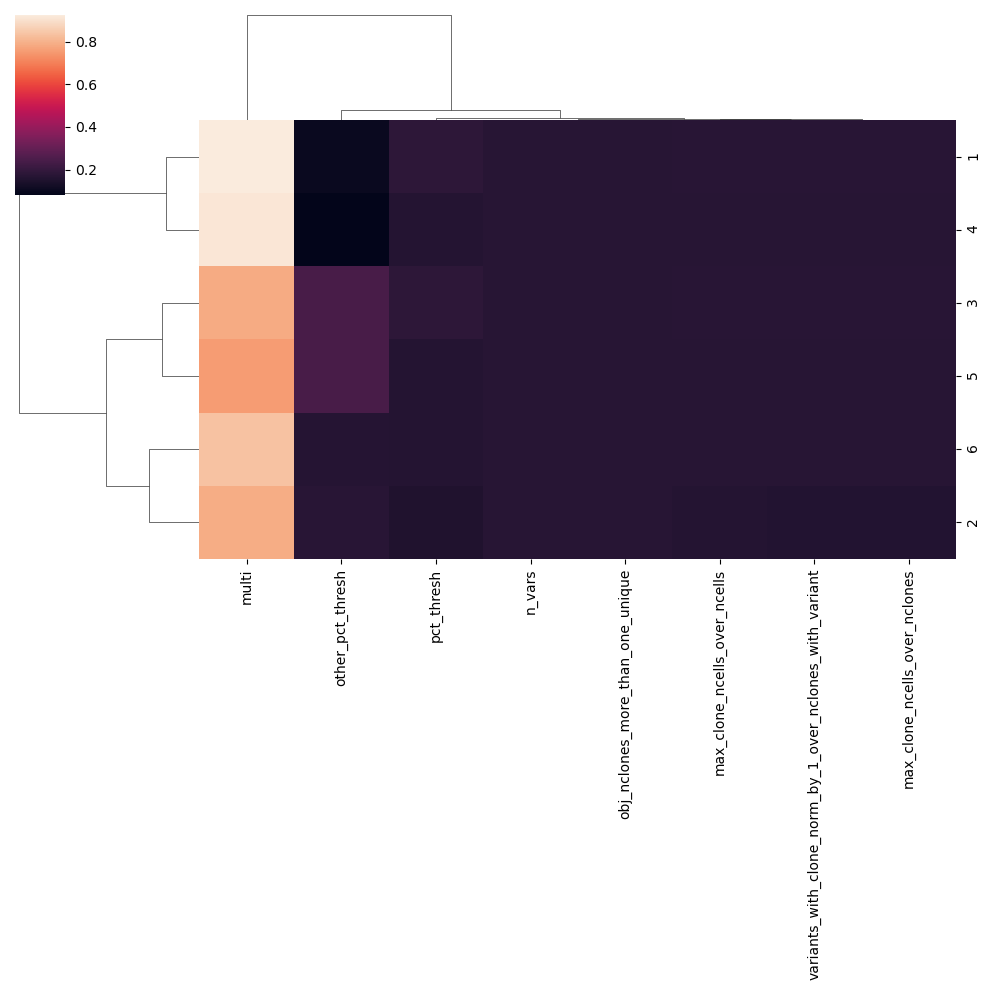

In [22]:
if results_norm.shape[0] == 1:
    sns.heatmap(results_norm.fillna(0))
else:
    sns.clustermap(results_norm.fillna(0))
plt.savefig(join(outdir, "top_param_group_results.png"))
plt.savefig(join(outdir, "top_param_group_results.pdf"), dpi=300, bbox_inches='tight', pad_inches=1)

## Plot cluster clone-var table

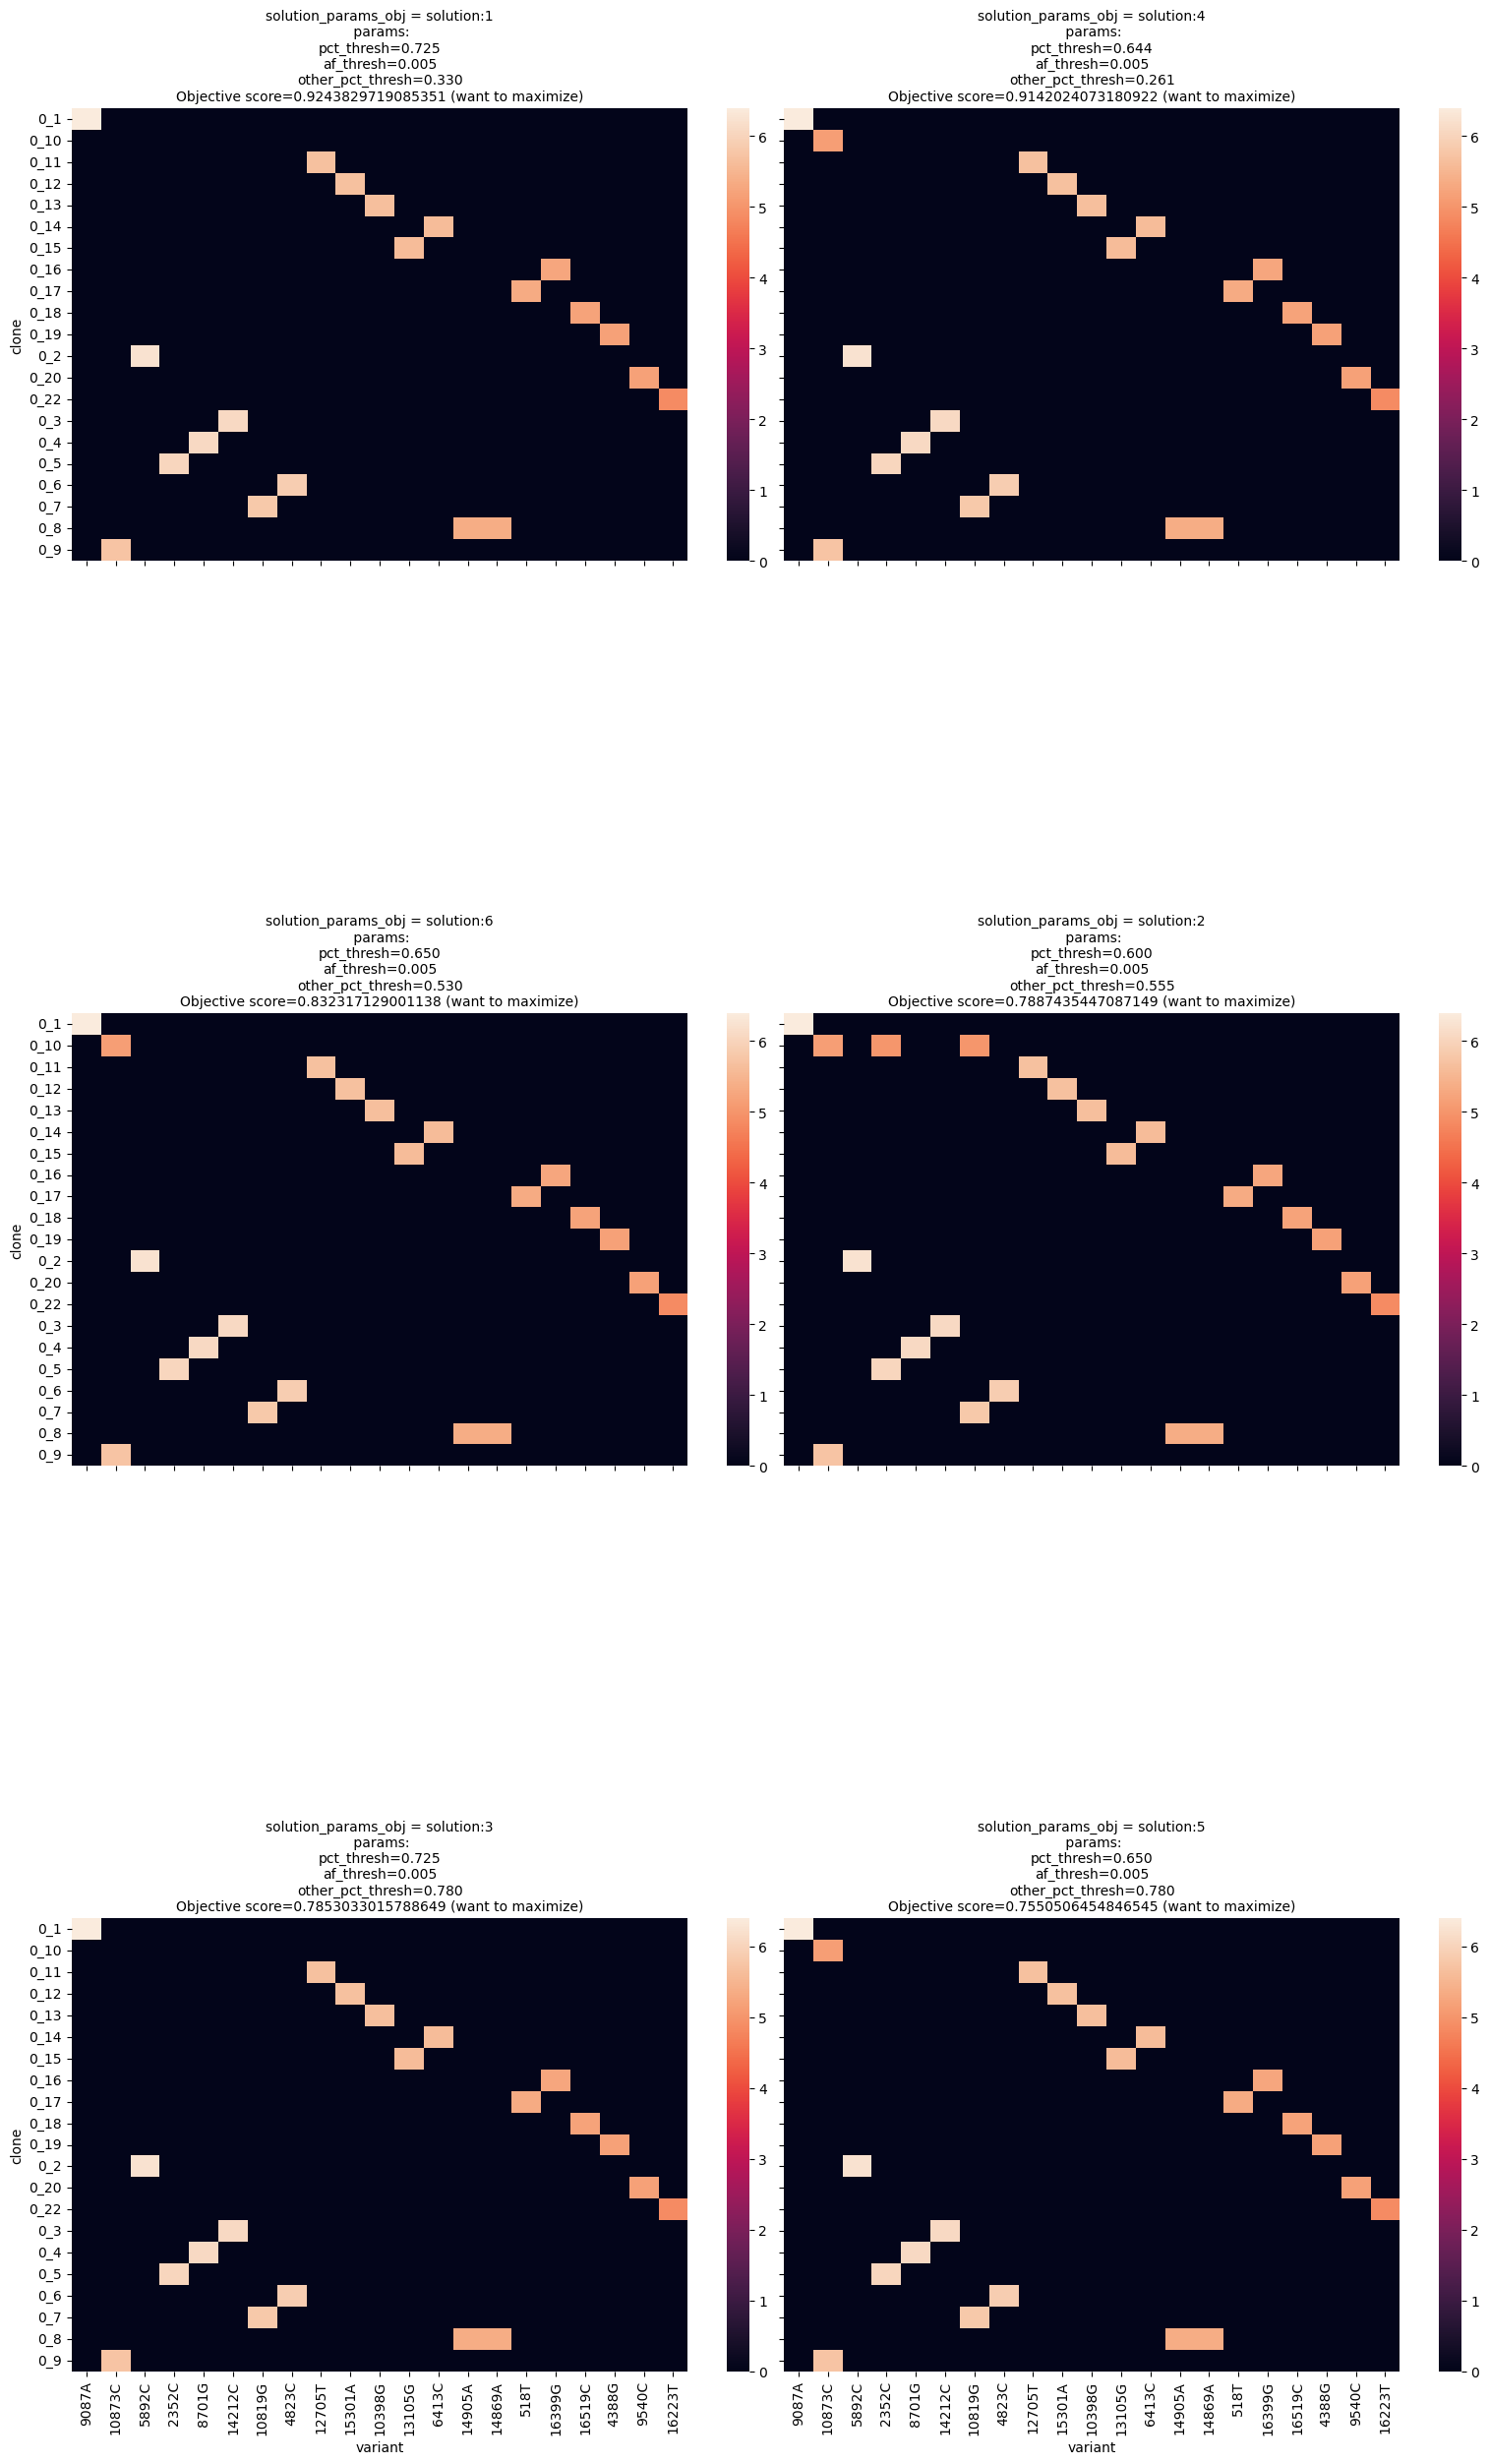

In [23]:
fg = sns.FacetGrid(data=all_df.reset_index(), height=4, aspect=2, sharey=True, sharex=True, 
                   col="solution_params_obj", col_wrap=2, 
                   col_order=results_norm_params["solution_params_obj"].values, margin_titles=False)

fg.map_dataframe(optim.draw_heatmap, 'variant','clone', 'log2_n_cells', 
                 clones_order=clones_order, 
                 variants_order=variants_order)#, cbar=False)
#fg.set_titles(row_template = 'other_pct_thresh: {row_name}', col_template = 'pct_thresh: {col_name}')
#fg.fig.suptitle(f"Best parameter combinations shown in order")
fg.fig.subplots_adjust(top=2, hspace = 1)

plt.savefig(join(outdir, "top_param_groups_clone_vars.pdf"), dpi=300, bbox_inches='tight', pad_inches=1)

In [24]:
for ind, val in all_df.groupby("solution_params_obj"):
    print(ind)
    curr_dir = join(outdir, "best_params_clusters")
    if not exists(curr_dir):
        os.mkdir(curr_dir)
    curr_name = val["params"][0].replace("=", "__").replace("\n", "___").strip("_")
    curr_table = val.reset_index().pivot(index="clone",columns="variant",values="n_cells").fillna(0).astype(int)
    curr_table.to_csv(join(curr_dir, f"clone_variants.{curr_name}.csv"))

solution:1
 params:
pct_thresh=0.725
af_thresh=0.005
other_pct_thresh=0.330
Objective score=0.9243829719085351 (want to maximize)
solution:2
 params:
pct_thresh=0.600
af_thresh=0.005
other_pct_thresh=0.555
Objective score=0.7887435447087149 (want to maximize)
solution:3
 params:
pct_thresh=0.725
af_thresh=0.005
other_pct_thresh=0.780
Objective score=0.7853033015788649 (want to maximize)
solution:4
 params:
pct_thresh=0.644
af_thresh=0.005
other_pct_thresh=0.261
Objective score=0.9142024073180922 (want to maximize)
solution:5
 params:
pct_thresh=0.650
af_thresh=0.005
other_pct_thresh=0.780
Objective score=0.7550506454846545 (want to maximize)
solution:6
 params:
pct_thresh=0.650
af_thresh=0.005
other_pct_thresh=0.530
Objective score=0.832317129001138 (want to maximize)


## Get the top cluster score and save 

In [25]:
best_params = (results_norm_params.sort_values("multi_obj")[::-1]).iloc[0]
best_params

best_params = pd.DataFrame(best_params).transpose()
best_params.index = ["objective_scores"]
best_params.loc["weight"] = None

for obj, w in zip(objectives_l, weights):
    best_params.loc["weight", f"{obj}_obj"] = w

out_df = all_df[all_df['params'] == best_params.loc["objective_scores", "params"]]

clone_var_table = (out_df.pivot(index= 'variant',columns='clone', values='log2_n_cells').fillna(0))
clones_keep = clone_var_table.loc[:, ~((clone_var_table==0).all(axis=0))].columns
vars_keep = clone_var_table.loc[~((clone_var_table==0).all(axis=1))].index


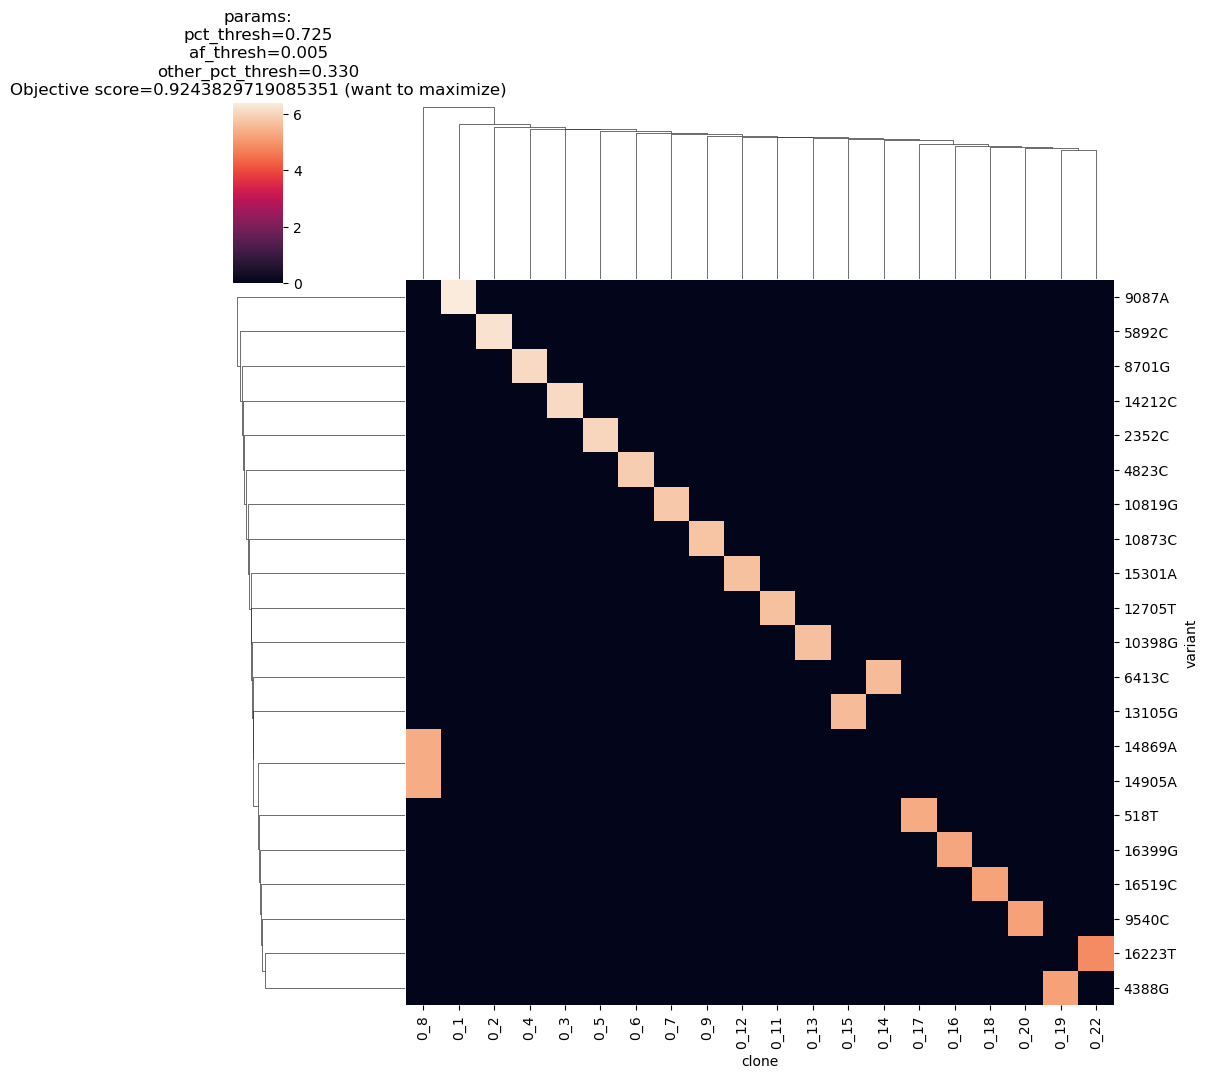

In [26]:
sns.clustermap(clone_var_table)
plt.title(best_params.loc["objective_scores", "params_multi"])
plt.savefig(join(outdir, "best_params.pdf"), dpi=300, bbox_inches='tight', pad_inches=1)

# sns.clustermap(clone_var_table.loc[vars_keep,clones_keep])
# plt.title(best_params.loc["objective_scores", "params_multi"])
# plt.savefig(join(outdir, "best_params_filt.pdf"))



In [27]:
# ## Save clone-variant table and the parameters
clone_var_table.to_csv(join(outdir, "best_params_clone_vars.csv"))
clone_var_table.loc[vars_keep,clones_keep].to_csv(join(outdir, "best_params_filt_clone_vars.csv"))
best_params.to_csv(join(outdir, "best_params.csv"))

anno_cells = pd.read_csv(anno_cells_meta_f, sep="\t", index_col=0)

filt_curr_labels = curr_labels[curr_labels["name"].isin(clones_keep)]

# overlap cells of anno and curr labels
cells_to_keep = set(anno_cells["ID"].values).intersection(set(filt_curr_labels.index))
out_cells_meta = anno_cells.loc[anno_cells["ID"].isin(cells_to_keep)]
#out_cells_meta =  out_cells_meta.reset_index().set_index("ID")

# out_AF_df = AF_df.loc[vars_keep, out_cells_meta.index]
# out_DP_df = DP_df.loc[vars_keep, out_cells_meta.index]
print(out_cells_meta.head())
out_AF_df = AF_df.loc[vars_keep, out_cells_meta["ID"]].transpose()
out_DP_df = DP_df.loc[vars_keep, out_cells_meta["ID"]].transpose()


print(out_cells_meta.shape)
print(out_AF_df.shape)
print(out_DP_df.shape)

assert((out_AF_df.index==out_DP_df.index).all())
assert((out_AF_df.columns==out_DP_df.columns).all())
assert((out_AF_df.index==out_cells_meta["ID"]).all())


# ## save cells-meta, af and dp
out_cells_meta["ID"]

out_cells_meta.to_csv(join(outdir, "cells_meta.tsv"),sep="\t")
out_AF_df.to_csv(join(outdir, "af.tsv"), sep="\t")
out_DP_df.to_csv(join(outdir, "dp.tsv"), sep="\t")

outdir



                         orig.ident  nCount_ATAC  nFeature_ATAC  total  \
Input_AAACGAAAGCCGCAAA-1      Input         1032           1032  16081   
Input_AAACGAACAGATGGCA-1      Input         5950           5950  44699   
Input_AAACGAATCAGAGTGG-1      Input         1558           1558  10961   
Input_AAACTGCAGTAGGAAG-1      Input         5657           5657  25485   
Input_AAACTGCAGTAGTTCC-1      Input         4235           4235  22515   

                          duplicate  chimeric  unmapped  lowmapq  \
Input_AAACGAAAGCCGCAAA-1       1250        25        60      379   
Input_AAACGAACAGATGGCA-1      10292       190       169     1753   
Input_AAACGAATCAGAGTGG-1       1743        56        43      289   
Input_AAACTGCAGTAGGAAG-1       6046       143       103      784   
Input_AAACTGCAGTAGTTCC-1       4304       118        66      740   

                          mitochondrial  passed_filters  ... seurat_clusters  \
Input_AAACGAAAGCCGCAAA-1          11724            2643  ...      

'/data/Mito_Trace/output/pipeline/v04/CHIP_b2/InputOnly/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/clones/variants_prefilterMerge_impute/knn/kparam_30/donor0/optim_results/'

# plot top n

In [28]:
# ########################
# # Get the top n results
# ########################
# def get_top_n_results(results_df, rank_df, n=12):
#     filt_rank = rank_df.sort_values(by=["multi"])[::-1].iloc[:n]
#     filt_results = results_df.loc[filt_rank.index]
#     return filt_rank, filt_results


# full_params.to_csv(join(outdir, "params.csv"))

# filt_rank, filt_results = get_top_n_results(results_norm, rank_df, n=topn)
# filt_results.columns = [f"{x}_obj" for x in filt_results.columns]
# filt_results = pd.merge(filt_results, full_params, left_index=True, right_index=True, how="left")
# filt_rank = filt_rank.loc[filt_results.index]

# all_df = []
# all_objs = {}
# for ind, val in filt_results.iterrows():
#     print(ind)
#     obj_out, data = optim.evaluate_series(val, AF_df, DP_df, curr_labels, return_data=True)
#     all_df.append(data["all_unique_df"])
#     all_objs[ind] = obj_out 
# all_df = pd.concat(all_df)

# heatmap_input = all_df[["n_cells", "variant"]].reset_index().pivot(index="id", columns="variant", values="n_cells").fillna(0).astype(int)
# meta_df = all_df[["af_thresh", "other_pct_thresh", "pct_thresh", "clone"]]
# meta_df = meta_df.loc[~(meta_df.index.duplicated())]
# meta_df = meta_df.sort_values(["af_thresh","pct_thresh", "other_pct_thresh", "clone"])
# heatmap_input = heatmap_input.loc[meta_df.index]

# # Get the variants based on total number of cells across parameters
# heatmap_input = heatmap_input.loc[:,heatmap_input.sum().sort_values()[::-1].index]
# variants_order = heatmap_input.columns


# clone_sums = meta_df.groupby("clone").apply(optim.clone_sum, heatmap_input)
# clone_sums = clone_sums.loc[:, clone_sums.sum().sort_values()[::-1].index]
# clones_order = clone_sums.index

# all_df["params"] = all_df.apply(optim.params_to_str, axis=1, args=(param_names,))
# filt_results["params"] = filt_results.apply(optim.params_to_str, axis=1, args=(param_names,))
# filt_results["params_multi"] = filt_results.apply(optim.params_and_multi_str, axis=1)
# tmp = filt_results.set_index("params")
# all_df["multi_obj"] = all_df.apply(lambda x: tmp.loc[x["params"], "multi_obj"], axis=1)
# del tmp                               

# all_df["params_multi"] = all_df.apply(optim.params_and_multi_str, axis=1)


# fg = sns.FacetGrid(data=all_df.reset_index(), height=4, sharey=False, sharex=False,
#                    col="params", col_wrap=4, col_order=filt_results["params"].values, margin_titles=True)

# fg.map_dataframe(optim.draw_heatmap, 'variant','clone', 'log2_n_cells',
#                  clones_order=clones_order, variants_order=variants_order)#, cbar=False)

# #fg.set_titles(row_template = 'other_pct_thresh: {row_name}', col_template = 'pct_thresh: {col_name}')
# fg.fig.suptitle(f"Best parameter combinations shown in order")
# fg.fig.subplots_adjust(top=0.9, hspace = 0.8)

# plt.title("multiobjective function (want to maximize)")
# #plt.savefig(join(outdir, "top_param_results.pdf"))
# plt.savefig(join(outdir, "top_param_results.pdf"), dpi=300)